# ***Adversarial Training Legal BERT***

This notebook combines the LegalBert model classifier as well as the trigger generation. The implementation is structured as follows:
* Read files
* Generate tokens (no natural). The previous model is taken into consideration to know what words make the model to perform the worst. N (100) candidates are taken per token (i.e. if it's desired to generate 3 tokens that will be added (concatenated) at the beginning, end or randomly. Then, 100 candidates are taken per each of those 3 tokens). These values are stored in and array, s.t. at the end, we can create new sentences using them.
* Data Augmentation. Generated tokens are used to generate new sentences.
* Adversarial training. A new model is created using the original dataset and the augmented samples.


Technnological details:
* Model name: LegalBert (nlpaueb/legal-bert-small-uncased)
* Class model: BertForSequenceClassification
* Batch size: 16|32
* Embedding size: 512 (default)
* Dataset: Claudette (Terms of Service)
* Num classes: 2 (just considered as a binary classification as {Fair|Unfair} sentences)
* Vocabulary size: 30,522 (default)
* Num tokens: 3|4|6

### Global variables

In [2]:
# Global variables

BATCH_SIZE = 32
MODEL_NAME = 'nlpaueb/legal-bert-small-uncased'#'bert-base-uncased'
EPOCHS = 3
EMBEDDING_SIZE = 512
NUM_CLASSES = 2
VOCABULARY_SIZE = 30522
NUM_TOKENS = 10
DEFAULT_TOKEN = 207 # What in BERT represents the word "the"
LIST_ID_SPECIAL_TOKENS = [0, 101, 102, 103]
LIST_SPECIAL_TOKENS = ['[PAD]', '[CLS]', '[SEP]', '[MASK]']

### Installation of packages

In [3]:
!pip install transformers
!pip install torch-lr-finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 16.7 MB/s 
     |████████████████████████████████| 101 kB 10.8 MB/s 
     |████████████████████████████████| 6.6 MB 66.5 MB/s 
     |████████████████████████████████| 596 kB 54.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Imports

In [4]:
import torch
import os
from transformers import BertTokenizer
from google.colab import drive
from torch.utils.data import TensorDataset, random_split
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
import random
import gc
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from copy import deepcopy
from datetime import datetime
import datetime

### Mount on GoogleDrive

In [5]:
# Mount drive to have access to your files
drive.mount('/content/drive')
%cd /content/drive/MyDrive/"Colab Notebooks"/DefenseAdvAttacks

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/DefenseAdvAttacks


### Device

In [6]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Reading original dataset

In [7]:
# Funtion to read all sentences
def get_sentences(path):
    sentences= []
    for filename in sorted(os.listdir(path)):
        with open(path+filename, 'r') as f:
            for sentence in f :
                if sentence.strip() != '':
                    sentences.append(sentence)
    return sentences

# Function to read get all labels
def get_labels(path):
    all_labels = []
    for filename in sorted(os.listdir(path)):
        file_labels = []
        with open(path+filename, 'r') as f:
            for label in f :
                if label.strip() != '':
                    all_labels.append(int(label))
    return all_labels

In [8]:
# Reading sentences and labels of the Claudette Dataset
all_sentences = get_sentences("ToS/TrainValSet/Sentences/")
all_labels = get_labels("ToS/TrainValSet/Labels/")

# Conversion of unfair sentence's flag|tag. Since unfair sentences are marked as "-1", we change them to "0" for simplicity. 
#   Zero means fair, 
#   One means unfair
all_labels =  [0 if label ==-1 else label for label in all_labels]

## **Trigger Generation**

### Bert (Model, Tokenizer and Load)

In [9]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True) # the model 'bert-base-uncased' only contains lower case sentences

Loading BERT tokenizer...


In case that it's desired to know basic functions how to convert sentences to tokens or the other way around.

```
# ==> Example of first sentence

# Print the original sentence.
print(' Original: ', all_sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(all_sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(all_sentences[0])))
```



To get the max length of a sentence within the dataset (sentences that have been already read)
```
# ==> Get the max length of a sentence

max_len = 0

# For every sentence...
for sent in all_sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)
```

Output:
```
Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors

Max sentence length:  598
```



### Model BertForSequenceClassification (Load model)

In [10]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = NUM_CLASSES, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at nlpaueb/legal-bert-small-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

In [11]:
# Load the model and dictionary
model.load_state_dict(torch.load('Bert4SeqClassif_20220804_1134_wPersistency.pt'))#, map_location=torch.device('cpu') or cuda. Both work

<All keys matched successfully>

### Trigger generation

##### General functions

In [12]:
# hook used in add_hooks()
extracted_grads = []
def extract_grad_hook(module, grad_in, grad_out):
    extracted_grads.append(grad_out[0])

# returns the wordpiece embedding weight matrix
def get_embedding_weight(language_model):
    for module in language_model.modules():
        if isinstance(module, torch.nn.Embedding):
            if module.weight.shape[0] == 30522: # only add a hook to wordpiece embeddings, not position embeddings 
                ##50257 is the size of the vocabulary of GPT
                return module.weight.detach()

# add hooks for embeddings
def add_hooks(language_model):
    for module in language_model.modules():
        if isinstance(module, torch.nn.Embedding):
            if module.weight.shape[0] == 30522: # only add a hook to wordpiece embeddings, not position
                ##50257 is the size of the vocabulary of GPT
                module.weight.requires_grad = True
                #module.register_backward_hook(extract_grad_hook)
                module.register_full_backward_hook(extract_grad_hook)


# creates the batch of target texts with -1 placed at the end of the sequences for padding (for masking out the loss).
def make_target_batch(tokenizer, device, target_texts):
    # encode items and get the max length
    encoded_texts = []
    max_len = 0
    for target_text in target_texts:
        encoded_target_text = tokenizer.encode_plus(
            target_text,
            add_special_tokens = True,
            max_length = EMBEDDING_SIZE - NUM_TOKENS,
            pad_to_max_length = True,
            return_attention_mask = True
        )
        encoded_texts.append(encoded_target_text.input_ids)
        if len(encoded_target_text.input_ids) > max_len:
            max_len = len(encoded_target_text)

    # pad tokens, i.e., append -1 to the end of the non-longest ones
    for indx, encoded_text in enumerate(encoded_texts):
        if len(encoded_text) < max_len:
            encoded_texts[indx].extend([-1] * (max_len - len(encoded_text)))

    # convert to tensors and batch them up
    target_tokens_batch = None
    for encoded_text in encoded_texts:
        target_tokens = torch.tensor(encoded_text, device=device, dtype=torch.long).unsqueeze(0)
        if target_tokens_batch is None:
            target_tokens_batch = target_tokens
        else:
            target_tokens_batch = torch.cat((target_tokens, target_tokens_batch), dim=0)
    return target_tokens_batch

# Got from https://github.com/Eric-Wallace/universal-triggers/blob/master/attacks.py
def hotflip_attack(averaged_grad, embedding_matrix, trigger_token_ids,
                   increase_loss=False, num_candidates=1):
    """
    The "Hotflip" attack described in Equation (2) of the paper. This code is heavily inspired by
    the nice code of Paul Michel here https://github.com/pmichel31415/translate/blob/paul/
    pytorch_translate/research/adversarial/adversaries/brute_force_adversary.py
    This function takes in the model's average_grad over a batch of examples, the model's
    token embedding matrix, and the current trigger token IDs. It returns the top token
    candidates for each position.
    If increase_loss=True, then the attack reverses the sign of the gradient and tries to increase
    the loss (decrease the model's probability of the true class). For targeted attacks, you want
    to decrease the loss of the target class (increase_loss=False).
    """
    averaged_grad = averaged_grad.cpu()
    embedding_matrix = embedding_matrix.cpu()
    trigger_token_embeds = torch.nn.functional.embedding(torch.LongTensor(trigger_token_ids),
                                                         embedding_matrix).detach().unsqueeze(0)
    averaged_grad = averaged_grad.unsqueeze(0)
    gradient_dot_embedding_matrix = torch.einsum("bij,kj->bik",
                                                 (averaged_grad, embedding_matrix))        
    if not increase_loss:
        gradient_dot_embedding_matrix *= -1    # lower versus increase the class probability.
    if num_candidates > 1: # get top k options
        _, best_k_ids = torch.topk(gradient_dot_embedding_matrix, num_candidates, dim=2)
        return best_k_ids.detach().cpu().numpy()[0]
    _, best_at_each_step = gradient_dot_embedding_matrix.max(2)
    return best_at_each_step[0].detach().cpu().numpy()

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [13]:
def get_input_masks_and_labels_with_tokens(sentences, labels, tokens, position='B'):
    input_ids = []
    attention_masks = []
    number_of_tokens = []

    for sent in sentences:

        if position == 'B':
            sent_with_tokens = tokens + " " + sent
        elif position == 'E':
            sent_with_tokens = sent + " " + tokens
        else:
            print('Wrong position command, please enter "E" or "B"')
            return

        encoded_dict = tokenizer.encode_plus(
                        sent_with_tokens,
                        add_special_tokens = True,
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )


        input_ids.append(encoded_dict['input_ids'])

        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    # count number of tokens of each sentence
    for idx in range(len(input_ids)):
      sent_ids = input_ids[idx, :]

      cnt = 0
      for id in sent_ids:
          if id != 0:
              cnt += 1

      number_of_tokens.append(cnt)  

    return input_ids, attention_masks, labels, number_of_tokens

In [14]:
def get_loss_and_metrics(model, dataloader, device):
    # get initial loss for the trigger
    model.zero_grad()

    test_preds = []
    test_targets = []

    # Tracking variables 
    total_test_accuracy = 0
    total_test_loss = 0
    io_total_test_acc = 0
    io_total_test_prec = 0
    io_total_test_recall = 0
    io_total_test_f1 = 0

    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        result = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels,
                    return_dict=True)

        loss = result.loss
        logits = result.logits

        test_preds.extend(logits.argmax(dim=1).cpu().numpy())
        test_targets.extend(batch[2].numpy())

        # Accumulate the validation loss.
        total_test_loss += loss.item()

        test_preds.extend(logits.argmax(dim=1).cpu().numpy())
        test_targets.extend(batch[2].numpy())

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        loss.backward()        

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.        
        test_acc = accuracy_score(test_targets, test_preds)
        test_precision = precision_score(test_targets, test_preds)
        test_recall = recall_score(test_targets, test_preds)
        test_f1 = f1_score(test_targets, test_preds)

        io_total_test_acc += test_acc
        io_total_test_prec += test_precision
        io_total_test_recall += test_recall
        io_total_test_f1 += test_f1

    io_avg_test_loss = total_test_loss/len(dataloader)
    io_avg_test_acc = io_total_test_acc / len(dataloader)
    io_avg_test_prec = io_total_test_prec / len(dataloader)
    io_avg_test_recall = io_total_test_recall / len(dataloader)
    io_avg_test_f1 = io_total_test_f1 / len(dataloader)
    """
    print(
            f'Loss {io_avg_test_loss} : \t\
            Valid_acc : {io_avg_test_acc}\t\
            Valid_F1 : {io_avg_test_f1}\t\
            Valid_precision : {io_avg_test_prec}\t\
            Valid_recall : {io_avg_test_recall}'
          )
    """

    return io_avg_test_loss, io_avg_test_acc, io_avg_test_prec, io_avg_test_recall, io_avg_test_f1

In [15]:
def change_input_ids_with_candidate_token(input_ids, position, candidate, number_of_tokens, trigger_position='B'):
    if trigger_position == 'B':
        input_ids[:, position] = candidate
    elif trigger_position == 'E':
        for idx in range(len(input_ids)):
            if number_of_tokens[idx] > EMBEDDING_SIZE:
                input_ids[idx, EMBEDDING_SIZE-NUM_TOKENS-2+position] = candidate
            else:
                input_ids[idx, number_of_tokens[idx]-NUM_TOKENS-2+position] = candidate
    else:
        print('Wrong position command, please enter "E" or "B"')
        return
    return input_ids

##### Execution of the trigger generation

###### Get unfair sentences

In [16]:
positions_unfair = np.where(np.array(all_labels) == 1)[0]
print(f'First 32 positions: {positions_unfair[0:32]} with total of unfair sentences {len(positions_unfair)}')

target_unfair_sentences = []
labels_unfair_sentences = []
for index in range(len(positions_unfair)):
    target_unfair_sentences.append(all_sentences[positions_unfair[index]])
    labels_unfair_sentences.append(all_labels[positions_unfair[index]])

# Initialization of tokens with the particle "the" whose id number in BERT model is 207
trigger_tokens = np.array([DEFAULT_TOKEN]*NUM_TOKENS)
print(tokenizer.decode(trigger_tokens))

First 32 positions: [  7  12  15  24  26  48  54  57  61  62  77  93 102 104 143 151 161 163
 183 194 200 205 219 226 237 241 244 265 275 278 282 294] with total of unfair sentences 991
the the the the the the the the the the


###### Addition of hooks and get word embeddings

In [17]:
model.eval()
model.to(device)

add_hooks(model) # add gradient hooks to embeddings
embedding_weight = get_embedding_weight(model) # save the word embedding matrix

###### Get tensors and creation of dataset and dataloader

In [18]:
## Define at which position we want to have the triggers
position = 'B' # Possible values {B|E} for beginning and end, respectively

input_ids, attention_masks, labels, number_of_tokens = get_input_masks_and_labels_with_tokens(target_unfair_sentences, labels_unfair_sentences, tokenizer.decode(trigger_tokens), position=position)

dataset = TensorDataset(input_ids, attention_masks, labels)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


###### Execution of trigger generation

In [19]:
timestamp = datetime.datetime.now().strftime("%y%m%d_%H_%M_%S_%p")
f = open(f"Execution_Pos{position}_NumTokens_{NUM_TOKENS}_{timestamp}.txt", "w")

In [20]:
candidates_dict = {}
candidates_dict["combinations_ids"] = []
candidates_dict["combinations_labels"] = []
foundX = -1
foundY = -1
candidates_combination = [DEFAULT_TOKEN]*NUM_TOKENS
goalTag = 'Loss'

extracted_grads = []

loss_obtained, acc_obtained, prec_obtained, recall_obtained, f1_obtained = get_loss_and_metrics(model, dataloader, device)
#print(f'loss_obtained {loss_obtained}')

candidates_selected = [DEFAULT_TOKEN]*NUM_TOKENS
# try all the candidates and pick the best
curr_best_loss = loss_obtained
curr_best_trigger_tokens = None

print(f"{position}[{foundX:3},{foundY:3}] TokenID[{candidates_combination}] TokensDesc[{tokenizer.decode(candidates_combination)}] Loss[{loss_obtained:3.5}] Acc[{acc_obtained:3.5}] Prec[{prec_obtained:3.5}] Recall[{recall_obtained:3.5}] F1[{f1_obtained:3.5}] => Worst<<{goalTag}>>[{curr_best_loss:3.5}] Found at [{foundX:3},{foundY:3}]")
f.write(f'{position}[{foundX:3},{foundY:3}] TokenID[{candidates_combination}] TokensDesc[{tokenizer.decode(candidates_combination)}] Loss[{loss_obtained:3.5}] Acc[{acc_obtained:3.5}] Prec[{prec_obtained:3.5}] Recall[{recall_obtained:3.5}] F1[{f1_obtained:3.5}] => Worst<<{goalTag}>>[{curr_best_loss:3.5}] Found at [{foundX:3},{foundY:3}]')

for id_token_to_flip in range(0, NUM_TOKENS):

    averaged_grad = torch.sum(extracted_grads[0], dim=0)
    averaged_grad = averaged_grad[id_token_to_flip].unsqueeze(0)

    # Use hotflip (linear approximation) attack to get the top num_candidates
    candidates = hotflip_attack(averaged_grad, embedding_weight,
                                        [trigger_tokens[id_token_to_flip]], 
                                        increase_loss=False, num_candidates=100)[0]
    print(f'candidates {candidates}')
    f.write(f'{position} candidates {candidates}')
    candidates_dict[id_token_to_flip] = candidates
    
    for index, cand in enumerate(candidates):
        extracted_grads = []

        if cand in LIST_ID_SPECIAL_TOKENS:
          continue

        input_ids_with_candidate_trigger = change_input_ids_with_candidate_token(deepcopy(input_ids), id_token_to_flip+1, cand, number_of_tokens, trigger_position=position)
        dataset_with_candidate_trigger = TensorDataset(input_ids_with_candidate_trigger, attention_masks, labels)
        dataloader_with_candidate_trigger = torch.utils.data.DataLoader(dataset_with_candidate_trigger, batch_size=BATCH_SIZE)

        current_loss, current_acc, current_prec, current_recall, current_f1 = get_loss_and_metrics(model, dataloader_with_candidate_trigger, device)

        if curr_best_loss < current_loss:
            curr_best_loss = current_loss
            candidates_selected[id_token_to_flip] = cand

            foundX = id_token_to_flip
            foundY = index
        candidates_combination[id_token_to_flip] = cand
        candidates_dict["combinations_ids"].append(candidates_combination)
        candidates_dict["combinations_labels"].append(tokenizer.decode(candidates_combination))
        print(f'[{id_token_to_flip:3},{index:3}] TokenID[{candidates_combination}] TokensDesc[{tokenizer.decode(candidates_combination)}] Loss[{current_loss:3.5}] Acc[{current_acc:3.5}] Prec[{current_prec:3.5}] Recall[{current_recall:3.5}] F1[{current_f1:3.5}] => Worst<<{goalTag}>>[{curr_best_loss:3.5}] Found at [{foundX:3},{foundY:3}]')
        f.write(f'{position}[{id_token_to_flip:3},{index:3}] TokenID[{candidates_combination}] TokensDesc[{tokenizer.decode(candidates_combination)}] Loss[{current_loss:3.5}] Acc[{current_acc:3.5}] Prec[{current_prec:3.5}] Recall[{current_recall:3.5}] F1[{current_f1:3.5}] => Worst<<{goalTag}>>[{curr_best_loss:3.5}] Found at [{foundX:3},{foundY:3}]\n')
        
        del input_ids_with_candidate_trigger
        del dataset_with_candidate_trigger
        del dataloader_with_candidate_trigger

        gc.collect()
        torch.cuda.empty_cache()

        #print(f'Candidates selected {candidates_selected} VS candidates_combination {candidates_combination}')
        #print(f'[{id_token_to_flip}][{index}] loss[{index}] {current_loss} ({curr_best_loss})')

    candidates_combination = deepcopy(candidates_selected)
    #extracted_grads = []
    input_ids = change_input_ids_with_candidate_token(deepcopy(input_ids), id_token_to_flip+1, candidates_selected[id_token_to_flip], number_of_tokens, trigger_position=position)
    print(f'Worst loss {curr_best_loss} with candidates {candidates_selected} in the {id_token_to_flip}-iteration with tokens [{tokenizer.decode(candidates_selected)}]')
    f.write(f'{position}Worst loss {curr_best_loss} with candidates {candidates_selected}\n')
f.close()

B[ -1, -1] TokenID[[207, 207, 207, 207, 207, 207, 207, 207, 207, 207]] TokensDesc[the the the the the the the the the the] Loss[0.36082] Acc[0.91466] Prec[1.0] Recall[0.91466] F1[0.95527] => Worst<<Loss>>[0.36082] Found at [ -1, -1]
candidates [ 4303  5557   908 18883  2436   906 11734  2143  7716  9828  1534  1664
 13916  4599  6665   460 14170  8397  2399   608  1744  7391  1923  6493
  3053 18451  7770 15846  2012  3705  3641  1865  1791  6563   266  1824
 20750 21649   986  2225  2527  9496 18858  9148  4839  2823  2921 17225
 13417  6983   377 18554 17779  4691  4065  3566  5072  3643  4270  6021
 19052  3750  1126   579  1412  9978  8530 13248  4084  8625 12708  4374
 14391 15476  5340  6054  7396  5818 14225 11858 23063  3309 11865  1263
   753  1072 14479   699  6532  3770  6247  1968 21822 16204  2596  6637
 13959 11356  3437 29347]
[  0,  0] TokenID[[4303, 207, 207, 207, 207, 207, 207, 207, 207, 207]] TokensDesc[suffering the the the the the the the the the] Loss[0.34799] Acc

In [ ]:
#tokenizer.decode(candidates_selected) # B unless the everyone
tokenizer.decode(candidates_selected) # E signature scarcely contrary -> [1297, 17560, 207] or [1297, 17560, 1004]

# New tokens: B Worst loss 0.6033629960110111 with candidates [11858, 23347, 700] in the 2-iteration with tokens [telegram bnym him]
# New tokens: E Worst loss 0.41469741131990184 with candidates [1297, 14808, 16827] in the 2-iteration with tokens [signature understandable overcrowd]

'telegram bnym him'

##### Generate sentences with tokens

In [ ]:
len(target_unfair_sentences) #1032 bef; 991 now new distr 96(95-05)-4

991

In [ ]:
# Store new sentences with the tokens at the beginning
position="B"
list_tokens_deal_worst_loss = [
    tokenizer.decode([621, 207, 3523]), #unless the everyone
    tokenizer.decode([621, 207, 207]) #unless the the
]

dict_distribution = {
    0: 0,
    1: 0
}

timestamp = datetime.datetime.now().strftime("%y%m%d_%H_%M_%S_%p")
f = open(f"ToS/DataAugmentation/Pos{position}_NumTokens{NUM_TOKENS}_{timestamp}.txt", "w")

for unf_sent in target_unfair_sentences:
    index = 1 if random.uniform(0,1) > 0.5 else 0
    f.write(f'{list_tokens_deal_worst_loss[index]} {unf_sent}\n')
    dict_distribution[index] += 1
f.close()

print(dict_distribution) # {0: 508, 1: 524} => {0: 471, 1: 520} (96(95-05)-04))

{0: 471, 1: 520}


In [ ]:
# Store new sentences with the tokens at the beginning
position="E"
list_tokens_deal_worst_loss = [
    tokenizer.decode([1297, 17560, 1004]), #unless the everyone
    tokenizer.decode([1297, 17560, 431]) #unless the the
]

dict_distribution = {
    0: 0,
    1: 0
}

timestamp = datetime.datetime.now().strftime("%y%m%d_%H_%M_%S_%p")
f = open(f"ToS/DataAugmentation/Pos{position}_NumTokens{NUM_TOKENS}_{timestamp}.txt", "w")

for unf_sent in target_unfair_sentences:
    index = 1 if random.uniform(0,1) > 0.5 else 0

    sent_tokenized = tokenizer.encode(unf_sent)

    if len(sent_tokenized) > 507:
      str_aux = (tokenizer.decode(sent_tokenized[0:507])).replace("\n", "")
      f.write(f'{str_aux} {list_tokens_deal_worst_loss[index]}\n')
    else:
      str_aux = unf_sent.replace("\n", "")
      f.write(f'{str_aux} {list_tokens_deal_worst_loss[index]}\n')
    dict_distribution[index] += 1
f.close()

print(dict_distribution) # {0: 513, 1: 519} => {0: 492, 1: 499} (96(95-05)-04)

{0: 492, 1: 499}


## Training of a new model

The following code was the version for reading the sentences and labels that include the tokens at the beginning or the end.

This is changed later for the reading of the datasets (test; and train_val).



```
# Read unfair sentences with tokens

augmented_sentences = get_sentences("ToS/DataAugmentation/")
augmented_labels = [1]*len(augmented_sentences)

print(f'{len(augmented_labels)} ?= {len(augmented_sentences)}')

# Output:
# 2064 ?= 2064

##########################################

all_sentences_and_augmented = all_sentences + augmented_sentences
print(f'Length_sentences {len(all_sentences)} + Length_augmented {len(augmented_sentences)} = Len both sets {len(all_sentences_and_augmented)}')

# Output:
# Length_sentences 9414 + Length_augmented 2064 = Len both sets 11478

####

all_labels_and_augmented = all_labels + augmented_labels
print(f'Length_labels {len(all_sentences)} + Length_augmented {len(augmented_sentences)} = Len both sets {len(all_labels_and_augmented)}')

# Output:
# Length_labels 9414 + Length_augmented 2064 = Len both sets 11478

"""
1982 ?= 1982
Length_sentences 9037 + Length_augmented 1982 = Len both sets 11019
Length_labels 9037 + Length_augmented 1982 = Len both sets 11019
"""

```



### Data split

In [ ]:
all_sentences_and_augmented = get_sentences("ToS/TrainValSetWithAugmentedData/Sentences/")
all_labels_and_augmented = get_labels("ToS/TrainValSetWithAugmentedData/Labels/")

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in all_sentences_and_augmented:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,          # Pad & truncate all sentences.
                        pad_to_max_length = True, #is deprecated
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(all_labels_and_augmented)

# Print sentence 0, now as a list of IDs.
print('Original: ', all_sentences_and_augmented[0])
print('Token IDs:', input_ids[0])

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.
train_idx, valid_idx = train_test_split(np.arange(len(labels)), test_size=0.05, shuffle=True, stratify=labels)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
validation_dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  you agree to our data practices, including the collection, use, processing, and sharing of your information as described in our privacy policy, as well as the transfer and processing of your information to the united states and other countries globally where we have or use facilities, service providers, or partners, regardless of where you use our services.

Token IDs: tensor([ 101,  799,  753,  211, 1590,  586, 1748,  115,  283,  207, 1544,  115,
         355,  115, 1384,  115,  212, 2766,  235,  210, 1216,  286,  221,  735,
         213, 1590, 4407,  663,  115,  221,  705,  221,  207,  439,  212, 1384,
         210, 1216,  286,  211,  207,  354,  265,  212,  231,  779, 1506,  301,
         343,  532,  247,  215,  355, 1551,  115,  446, 3522,  115,  215, 1523,
         115, 2248,  210,  343,  799,  355, 1590,  410,  117,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  

The following code was developed to create the persistent files with the augmented data.



```
"""
print(type(train_idx))
print(len(train_idx))
print(train_idx[0:10])
print(type(train_sampler))

for index in train_idx[0:10]:
    print(f'{labels[index]} <<{tokenizer.decode(input_ids[index], skip_special_tokens=True)}>>')
"""

### Creation of the sets training, val and set. These sets are being stored to ensure persistency

# Let's first get the train_val and test set

# Create a 95-05 train-validation split.
train_val_ids, test_ids = train_test_split(np.arange(len(labels)), test_size=0.05, shuffle=True, stratify=labels)

timestamp = datetime.datetime.now().strftime("%y%m%d_%H_%M_%S_%p")
file_sentences_test_set = open(f"ToS/TestSetWithAugmentedData/Sentences/Sentences_{timestamp}.txt", "w")
file_labels_test_set = open(f"ToS/TestSetWithAugmentedData/Labels/Labels_{timestamp}.txt", "w")
for index in test_ids:
    sentence = (tokenizer.decode(input_ids[index], skip_special_tokens=True)).replace("\n", "")
    file_sentences_test_set.write(f'{sentence}\n')
    sentence = (f"{labels[index]}").replace("\n", "")
    file_labels_test_set.write(f'{sentence}\n')
file_sentences_test_set.close()
file_labels_test_set.close()

file_sentences_train_val_set = open(f"ToS/TrainValSetWithAugmentedData/Sentences/Sentences_{timestamp}.txt", "w")
file_labels_train_val_set = open(f"ToS/TrainValSetWithAugmentedData/Labels/Labels_{timestamp}.txt", "w")
for index in train_val_ids:
    sentence = (tokenizer.decode(input_ids[index], skip_special_tokens=True)).replace("\n", "")
    file_sentences_train_val_set.write(f'{sentence}\n')
    sentence = (f"{labels[index]}").replace("\n", "")
    file_labels_train_val_set.write(f'{sentence}\n')
file_sentences_train_val_set.close()
file_labels_train_val_set.close()
```



The following code was used to split the datasets into training-val and test sets without data augmentation.

```
all_sentences_and_augmented = all_sentences
all_labels_and_augmented = all_labels

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in all_sentences_and_augmented:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,          # Pad & truncate all sentences.
                        pad_to_max_length = True, #is deprecated
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(all_labels_and_augmented)

# Print sentence 0, now as a list of IDs.
print('Original: ', all_sentences_and_augmented[0])
print('Token IDs:', input_ids[0])

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.
train_idx, valid_idx = train_test_split(np.arange(len(labels)), test_size=0.05, shuffle=True, stratify=labels)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
validation_dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)

### Creation of the sets training, val and set. These sets are being stored to ensure persistency

# Let's first get the train_val and test set

# Create a 90-10 train-validation split.
train_val_ids, test_ids = train_test_split(np.arange(len(labels)), test_size=0.1, shuffle=True, stratify=labels)

timestamp = datetime.datetime.now().strftime("%y%m%d_%H_%M_%S_%p")
file_sentences_test_set = open(f"ToS/TestSet/Sentences/Sentences_{timestamp}.txt", "w")
file_labels_test_set = open(f"ToS/TestSet/Labels/Labels_{timestamp}.txt", "w")
for index in test_ids:
    sentence = (tokenizer.decode(input_ids[index], skip_special_tokens=True)).replace("\n", "")
    file_sentences_test_set.write(f'{sentence}\n')
    sentence = (f"{labels[index]}").replace("\n", "")
    file_labels_test_set.write(f'{sentence}\n')
file_sentences_test_set.close()
file_labels_test_set.close()

file_sentences_train_val_set = open(f"ToS/TrainValSet/Sentences/Sentences_{timestamp}.txt", "w")
file_labels_train_val_set = open(f"ToS/TrainValSet/Labels/Labels_{timestamp}.txt", "w")
for index in train_val_ids:
    sentence = (tokenizer.decode(input_ids[index], skip_special_tokens=True)).replace("\n", "")
    file_sentences_train_val_set.write(f'{sentence}\n')
    sentence = (f"{labels[index]}").replace("\n", "")
    file_labels_train_val_set.write(f'{sentence}\n')
file_sentences_train_val_set.close()
file_labels_train_val_set.close()
```


### Training classification model

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = NUM_CLASSES, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at nlpaueb/legal-bert-small-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

### Optimizer & Learning Rate Scheduler

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,#2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                  #weight_decay=0.3
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = EPOCHS

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
"""
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
"""
from torch.optim.lr_scheduler import CosineAnnealingLR
MIN_LR = 1e-5
scheduler = CosineAnnealingLR(optimizer, 600, eta_min = MIN_LR)

### Training

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    """
    print(f'preds.shape {preds.shape} == {preds}')
    print(f'labels.shape {labels.shape} == {labels}')
    """
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    """
    print(f'pred_flat.shape {pred_flat.shape} == {pred_flat}')
    print(f'labels_flat.shape {labels_flat.shape} == {labels_flat}')
    """
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
tr_metrics = []
va_metrics = []
tmp_print_flag = True


# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    train_loss = 0.0
    train_preds = []
    train_targets = []
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    io_total_train_acc = 0
    io_total_train_prec = 0
    io_total_train_recall = 0
    io_total_train_f1 = 0
    io_total_valid_acc = 0
    io_total_valid_prec = 0
    io_total_valid_recall = 0
    io_total_valid_f1 = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)
        """
        if tmp_print_flag:
          tmp_print_flag = False
          print(f'result.keys() = {result.keys()}')
        """

        loss = result.loss
        logits = result.logits

        """
        print(f'loss {loss}')
        print(f'logits {logits}')
        """
        train_preds.extend(logits.argmax(dim=1).cpu().numpy())
        train_targets.extend(batch[2].numpy())

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        train_acc = accuracy_score(train_targets, train_preds)
        train_precision = precision_score(train_targets, train_preds)
        train_recall = recall_score(train_targets, train_preds)
        train_f1 = f1_score(train_targets, train_preds)

        io_total_train_acc += train_acc
        io_total_train_prec += train_precision
        io_total_train_recall += train_recall
        io_total_train_f1 += train_f1

    io_avg_train_acc = io_total_train_acc / len(train_dataloader)
    io_avg_train_prec = io_total_train_prec / len(train_dataloader)
    io_avg_train_recall = io_total_train_recall / len(train_dataloader)
    io_avg_train_f1 = io_total_train_f1 / len(train_dataloader)
    print(
        f'Epoch {epoch_i+1} : \n\
        Train_acc : {io_avg_train_acc}\n\
        Train_F1 : {io_avg_train_f1}\n\
        Train_precision : {io_avg_train_prec}\n\
        Train_recall : {io_avg_train_recall}'
    )

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    valid_preds = []
    valid_targets = []

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits

        valid_preds.extend(logits.argmax(dim=1).cpu().numpy())
        valid_targets.extend(batch[2].numpy())

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
        valid_acc = accuracy_score(valid_targets, valid_preds)
        valid_precision = precision_score(valid_targets, valid_preds)
        valid_recall = recall_score(valid_targets, valid_preds)
        valid_f1 = f1_score(valid_targets, valid_preds)

        io_total_valid_acc += valid_acc
        io_total_valid_prec += valid_precision
        io_total_valid_recall += valid_recall
        io_total_valid_f1 += valid_f1

    io_avg_valid_acc = io_total_valid_acc / len(validation_dataloader)
    io_avg_valid_prec = io_total_valid_prec / len(validation_dataloader)
    io_avg_valid_recall = io_total_valid_recall / len(validation_dataloader)
    io_avg_valid_f1 = io_total_valid_f1 / len(validation_dataloader)
    print(
            f'Epoch {epoch_i+1} : \n\
            Valid_acc : {io_avg_valid_acc}\n\
            Valid_F1 : {io_avg_valid_f1}\n\
            Valid_precision : {io_avg_valid_prec}\n\
            Valid_recall : {io_avg_valid_recall}'
          )

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Accur.': io_avg_train_acc,
            'Training F1': io_avg_train_f1,
            'Training Precision': io_avg_train_prec, 
            'Training Recall': io_avg_train_recall,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Valid. F1': io_avg_valid_f1,
            'Valid. Precision': io_avg_valid_prec, 
            'Valid. Recall': io_avg_valid_recall,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch   100  of    311.    Elapsed: 0:00:43.
  Batch   200  of    311.    Elapsed: 0:01:28.
  Batch   300  of    311.    Elapsed: 0:02:13.
Epoch 1 : 
        Train_acc : 0.839764372371384
        Train_F1 : 0.6028437187510137
        Train_precision : 0.8130829078240804
        Train_recall : 0.5012945074488825

  Average training loss: 0.24
  Training epoch took: 0:02:18

Running Validation...
Epoch 1 : 
            Valid_acc : 0.9416478879109027
            Valid_F1 : 0.9016732403184603
            Valid_precision : 0.9172070685160991
            Valid_recall : 0.8870407304196881
  Accuracy: 0.95
  Validation Loss: 0.13
  Validation took: 0:00:02

======== Epoch 2 / 3 ========
Training...
  Batch   100  of    311.    Elapsed: 0:00:44.
  Batch   200  of    311.    Elapsed: 0:01:28.
  Batch   300  of    311.    Elapsed: 0:02:13.
Epoch 2 : 
        Train_acc : 0.9602152976562105
        Train_F1 : 0.92548299942023
        Train_precision : 0.

### Analysis

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Training Accur.,Training F1,Training Precision,Training Recall,Valid. Loss,Valid. Accur.,Valid. F1,Valid. Precision,Valid. Recall,Training Time,Validation Time
epoch,,,,,,,,,,,,
1,0.24,0.84,0.60,0.81,0.50,0.13,0.95,0.90,0.92,0.89,0:02:18,0:00:02
2,0.11,0.96,0.93,0.95,0.90,0.12,0.96,0.93,0.95,0.92,0:02:18,0:00:02
3,0.08,0.97,0.95,0.96,0.93,0.10,0.97,0.94,0.96,0.92,0:02:18,0:00:02


##### Loss per epoch - Training VS Validation

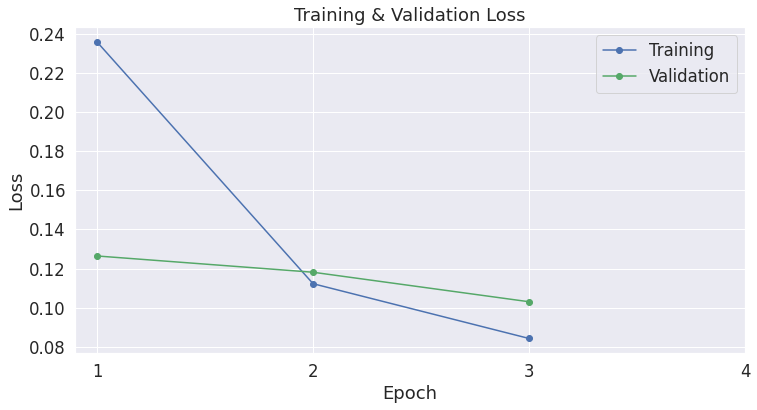

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

##### Accuracy per epoch - Training VS Validation

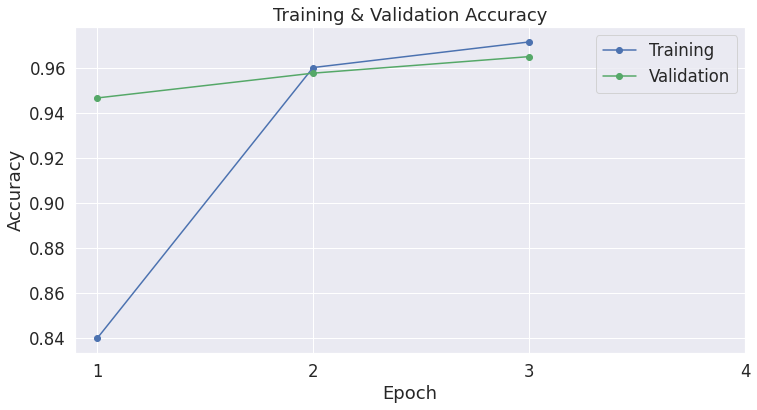

In [ ]:
# Plot the learning curve.
plt.plot(df_stats['Training Accur.'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Accur.'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

##### F1 per epoch - Training VS Validation

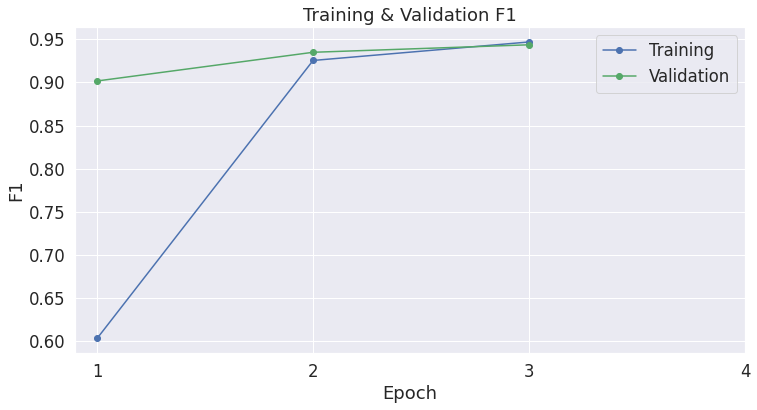

In [ ]:
# Plot the learning curve.
plt.plot(df_stats['Training F1'], 'b-o', label="Training")
plt.plot(df_stats['Valid. F1'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation F1")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

##### Recall per epoch - Training VS Validation

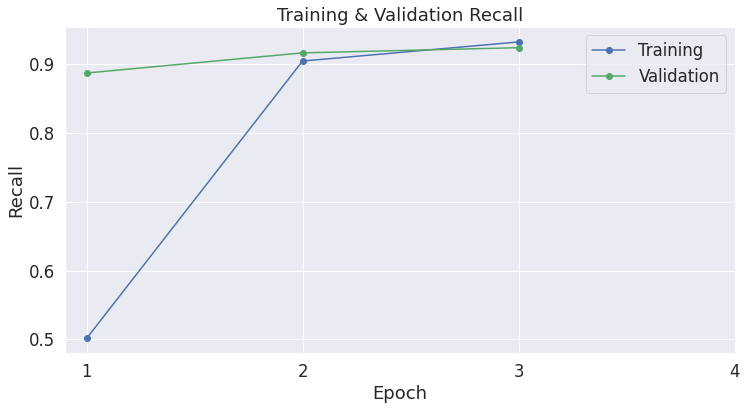

In [ ]:
# Plot the learning curve.
plt.plot(df_stats['Training Recall'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Recall'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### Save model

In [ ]:
#model_name = "Bert4SeqClassif_augm_20220804_1249.pt"
#torch.save(model.state_dict(), model_name)

## Testing the model

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = NUM_CLASSES, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

# Load the model and dictionary
model.load_state_dict(torch.load('Bert4SeqClassif_augm_20220804_1249.pt'))#, map_location=torch.device('cpu') or cuda. Both work #Bert4SeqClassif_20220804_1134_wPersistency.pt #Bert4SeqClassif_augm_20220804_1249.pt

Some weights of the model checkpoint at nlpaueb/legal-bert-small-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

<All keys matched successfully>

In [ ]:
# Reading sentences and labels from Testing set
all_sentences = get_sentences("ToS/TestSetWithAugmentedData/SentencesBeginning/") #TestSetWithAugmentedData
all_labels = get_labels("ToS/TestSetWithAugmentedData/LabelsBeginning/") #TestSet

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
tmp_bool = True

# For every sentence...
for sent in all_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,          # Pad & truncate all sentences.
                        pad_to_max_length = True, #is deprecated
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    if tmp_bool:
      tmp_bool = False
      print(f'Keys of encoded_dict: {encoded_dict.keys()}')
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(all_labels)

# Combine the training inputs into a TensorDataset.
test_dataset = TensorDataset(input_ids, attention_masks, labels)

test_dataloader = DataLoader(
            test_dataset,  # The test samples.
            sampler = RandomSampler(test_dataset), # Select batches randomly
            batch_size = BATCH_SIZE # Trains with this batch size.
        )

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Keys of encoded_dict: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [ ]:
# ========================================
#               Test
# ========================================
# After the completion of each test epoch, measure our performance on
# our test set.

print("Running Testing...")

t0 = time.time()

# Put the model in evaluation mode--the dropout layers behave differently
# during evaluation.
model.eval()

test_preds = []
test_targets = []

# Tracking variables 
total_test_accuracy = 0
total_test_loss = 0
nb_test_steps = 0

io_total_test_acc = 0
io_total_test_prec = 0
io_total_test_recall = 0
io_total_test_f1 = 0

# Evaluate data for one epoch
for batch in test_dataloader:
    
    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using 
    # the `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        result = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask,
                        labels=b_labels,
                        return_dict=True)

    # Get the loss and "logits" output by the model. The "logits" are the 
    # output values prior to applying an activation function like the 
    # softmax.
    loss = result.loss
    logits = result.logits

    test_preds.extend(logits.argmax(dim=1).cpu().numpy())
    test_targets.extend(batch[2].numpy())

    # Accumulate the test loss.
    total_test_loss += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences, and
    # accumulate it over all batches.
    total_test_accuracy += flat_accuracy(logits, label_ids)
    
    test_acc = accuracy_score(test_targets, test_preds)
    test_precision = precision_score(test_targets, test_preds)
    test_recall = recall_score(test_targets, test_preds)
    test_f1 = f1_score(test_targets, test_preds)

    io_total_test_acc += test_acc
    io_total_test_prec += test_precision
    io_total_test_recall += test_recall
    io_total_test_f1 += test_f1

    """
    print(
            f'Test_acc : {test_acc}\n\
            Test_F1 : {test_f1}\n\
            Test_precision : {test_precision}\n\
            Test_recall : {test_recall}\n\n\n'
          )
    """

# Report the final accuracy for this test run.
avg_test_accuracy = total_test_accuracy / len(test_dataloader)
print("  Accuracy: {0:.2f}".format(avg_test_accuracy))
avg_test_acc = io_total_test_acc / len(test_dataloader)
avg_test_prec = io_total_test_prec / len(test_dataloader)
avg_test_recall = io_total_test_recall / len(test_dataloader)
avg_test_f1 = io_total_test_f1 / len(test_dataloader)
print("  =>Accuracy:  {0:.2f}".format(avg_test_acc))
print("  =>Precision: {0:.2f}".format(avg_test_prec))
print("  =>Recall:    {0:.2f}".format(avg_test_recall))
print("  =>F1:        {0:.2f}".format(avg_test_f1))

# Calculate the average loss over all of the batches.
avg_test_loss = total_test_loss / len(test_dataloader)

# Measure how long the test run took.
test_time = format_time(time.time() - t0)

print("  Test Loss: {0:.2f}".format(avg_test_loss))
print("  Test took: {:}".format(test_time))


Running Testing...
  Accuracy: 0.97
  =>Accuracy:  0.97
  =>Precision: 0.91
  =>Recall:    0.79
  =>F1:        0.85
  Test Loss: 0.10
  Test took: 0:00:44


In [ ]:
len(all_sentences)

942

In [ ]:
test_sentences_without_tokens =  get_sentences("ToS/TrainValSet/Sentences/")
test_labels_without_tokens = get_labels("ToS/TrainValSet/Labels/")

In [ ]:
# Store new sentences with the tokens at the beginning
position="B"
list_tokens_deal_worst_loss = [
    tokenizer.decode([11858, 23347, 700]),#([621, 207, 3523]), #unless the everyone
    tokenizer.decode([11858, 23347, 2473])#([621, 207, 207]) #unless the the
]

dict_distribution = {
    0: 0,
    1: 0
}

timestamp = datetime.datetime.now().strftime("%y%m%d_%H_%M_%S_%p")
file_labels = open(f"ToS/TestSetWithAugmentedData/LabelsBeginning/Labels_Pos{position}_NumTokens{NUM_TOKENS}_{timestamp}.txt", "w")
file_sentences = open(f"ToS/TestSetWithAugmentedData/SentencesBeginning/Sentences_Pos{position}_NumTokens{NUM_TOKENS}_{timestamp}.txt", "w")

sentence_aux = ""
for type_sentence, sentence in zip(test_labels_without_tokens, test_sentences_without_tokens):
    sentence_aux = sentence.replace("\n", "")
    if type_sentence == 0:
        file_sentences.write(f'{sentence_aux}\n')
    else:
        index = 1 if random.uniform(0,1) > 0.5 else 0
        file_sentences.write(f'{list_tokens_deal_worst_loss[index]} {sentence_aux}\n')
        dict_distribution[index] += 1

    file_labels.write(f'{type_sentence}\n')
file_labels.close()
file_sentences.close()

print(dict_distribution) # {0: 503, 1: 488}

#############
"""
# Store new sentences with the tokens at the beginning
position="E"
list_tokens_deal_worst_loss = [
    tokenizer.decode([1297, 14808, 16827]),
    tokenizer.decode([1297, 14808, 7256])
]

dict_distribution = {
    0: 0,
    1: 0
}

timestamp = datetime.datetime.now().strftime("%y%m%d_%H_%M_%S_%p")
file_labels = open(f"ToS/TestSetWithAugmentedData/Labels/Labels_Pos{position}_NumTokens{NUM_TOKENS}_{timestamp}.txt", "w")
file_sentences = open(f"ToS/TestSetWithAugmentedData/Sentences/Sentences_Pos{position}_NumTokens{NUM_TOKENS}_{timestamp}.txt", "w")

sentence_aux = ""
for type_sentence, sentence in zip(test_labels_without_tokens, test_sentences_without_tokens):
    sentence_aux = sentence.replace("\n", "")
    if type_sentence == 0:
        file_sentences.write(f'{sentence_aux}\n')
    else:
        index = 1 if random.uniform(0,1) > 0.5 else 0
        file_sentences.write(f'{sentence_aux} {list_tokens_deal_worst_loss[index]}\n')
        dict_distribution[index] += 1

    file_labels.write(f'{type_sentence}\n')
file_labels.close()
file_sentences.close()

print(dict_distribution)

#{0: 495, 1: 496}
#{0: 510, 1: 481}
"""

{0: 503, 1: 488}


'\n# Store new sentences with the tokens at the beginning\nposition="E"\nlist_tokens_deal_worst_loss = [\n    tokenizer.decode([1297, 14808, 16827]),\n    tokenizer.decode([1297, 14808, 7256])\n]\n\ndict_distribution = {\n    0: 0,\n    1: 0\n}\n\ntimestamp = datetime.datetime.now().strftime("%y%m%d_%H_%M_%S_%p")\nfile_labels = open(f"ToS/TestSetWithAugmentedData/Labels/Labels_Pos{position}_NumTokens{NUM_TOKENS}_{timestamp}.txt", "w")\nfile_sentences = open(f"ToS/TestSetWithAugmentedData/Sentences/Sentences_Pos{position}_NumTokens{NUM_TOKENS}_{timestamp}.txt", "w")\n\nsentence_aux = ""\nfor type_sentence, sentence in zip(test_labels_without_tokens, test_sentences_without_tokens):\n    sentence_aux = sentence.replace("\n", "")\n    if type_sentence == 0:\n        file_sentences.write(f\'{sentence_aux}\n\')\n    else:\n        index = 1 if random.uniform(0,1) > 0.5 else 0\n        file_sentences.write(f\'{sentence_aux} {list_tokens_deal_worst_loss[index]}\n\')\n        dict_distribution[